# Notebook 3C - Post-hoc Explainability Methods
---

COSCI 222 - Machine Learning 2

- *Prepared by Leodegario U. Lorenzo II, updated by Kenneth T. Co*
- *Discussion adapted from Christoph Molnar's Interpretable Machine Learning* [[1]](#ref:molnar)

In [1]:
import pandas as pd
from matplotlib import rcParams

rcParams.update({'figure.figsize': (8, 6), 'axes.spines.top': False,
                 'axes.spines.right': False, 'axes.labelsize': 14,
                 'axes.titlesize': 16, 'axes.titleweight': 'bold',
                 'lines.linewidth': 3})

**Target**
1. `SeriousDlqin2yrs` - Person experienced 90 days past due delinquency or worse (Y/N)

**Features**

1. `RevolvingUtilizationOfUnsecuredLines` - Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits
2. `age` - Age of borrower in years
3. `NumberOfTime30-59DaysPastDueNotWorse` - Number of times borrower has been 30-59 days past due but no worse in the last 2 years.
4. `DebtRatio` - Monthly debt payments, alimony,living costs divided by monthy gross income
5. `MonthlyIncome` - Monthly income
6. `NumberOfOpenCreditLinesAndLoans` - Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)
7. `NumberOfTimes90DaysLate` - Number of times borrower has been 90 days or more past due.
8. `NumberRealEstateLoansOrLines` - Number of mortgage and real estate loans including home equity lines of credit
9. `NumberOfTime60-89DaysPastDueNotWorse` - Number of times borrower has been 60-89 days past due but no worse in the last 2 years.
10. `NumberOfDependents` - Number of dependents in family excluding themselves (spouse, children etc.)

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier


In [3]:
X, y = fetch_openml(data_id=43978, parser='auto', return_X_y=True)

In [4]:
X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(
    X, y, test_size=0.20, random_state=1337)

In [5]:
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', GradientBoostingClassifier())
])

In [6]:
pipe.fit(X_trainval, y_trainval);

# Counterfactual Explanations

## Intuition
*A counterfactual explanation of a prediction describes the smallest change to the feature values that change the prediction to a predefined output*.

Counterfactual explanation is inherently a local explainability method that can be used to explain predictions for giving instances from your dataset. It provides contrastive and human-friendly explanations as they can say which feature values to perturb in other to change the prediction of a given black box model.

<img title="Counter Factual Intuition" alt="CF Intuition" src="figures/counter-factual.gif" width="600">

<div class="alert alert-info">

### ⚠️ Question

Can you think of ways how we can create counterfactuals given any black box model (without access to training data)? How about with access to training data?
    
</div>

## Theory

Searching for counterfactual can be done in several ways. Knowing which type of model helps in the search but for our case, we'll consider a model agnostic approach for finding counterfactuals.

One method proposed by Dandl et. al. suggest ot simultaneously minimize a four-objective loss [[2]](#ref:dandl):

$$
L(x, x', y', X^{obs}) = (o_1(\hat{f}(x'), y'), o_2(x, x'), o_3(x, x'), o_4(x', X^{obs}))
$$

The first objective imposes that the prediction of the counterfactual $x'$ should be close possible to our desired prediction $y'$. The second objective $o_2$ imposes that the counterfactual be as similar as possible with the current instance $x$. The third objective puts a restraint on the number of features considered, as such this is our *sparsity criterion*. Then finally, the last objective imposes that the observed counterfactual be near an observed data point. $o_4$ also serves as an approximation for the likelihood.

The search algorithm for points that minimizes this objective function can then vary. Common methods include a randomized search, kd-tree based methods, gradient descent, and genetic algorithm methods.

## Implementation

In [7]:
# !pip install dice-ml

In [8]:
from dice_ml import Model, Dice, Data

In [9]:
model = Model(model=pipe, backend='sklearn')
dice_data = Data(
    dataframe=X_trainval.join(y_trainval),
    continuous_features=X.columns.tolist(),
    outcome_name='SeriousDlqin2yrs')
dice_exp = Dice(dice_data, model, method='genetic')

In [10]:
cfes1 = dice_exp.generate_counterfactuals(
    X_holdout.iloc[[0]],
    total_CFs=2,
    desired_class="opposite"
)
cfes1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

Query instance (original outcome : 1.0)


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,0.230358,62.0,1.0,1.91678,2210.0,16.0,1.0,2.0,0.0,0.0,1.0



Diverse Counterfactual set (new outcome: 0.0)


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,0.0168989,61.0,0.0,0.0,0.0,12.0,0.0,-,-,-,0.0
0,0.124683,53.0,0.0,2.1,-,12.0,0.0,-,-,-,0.0


In [11]:
cfes2 = dice_exp.generate_counterfactuals(
    X_holdout.iloc[[0]],
    total_CFs=3,
    desired_class="opposite",
    features_to_vary=["RevolvingUtilizationOfUnsecuredLines",
                      "DebtRatio", "NumberOfTimes90DaysLate",
                      "NumberOfTime30-59DaysPastDueNotWorse"]
)
cfes2.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

Query instance (original outcome : 1.0)


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,0.230358,62.0,1.0,1.91678,2210.0,16.0,1.0,2.0,0.0,0.0,1.0



Diverse Counterfactual set (new outcome: 0.0)


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,0.0474186,-,-,1.2,-,-,0.0,-,-,-,0.0
0,0.1997558,-,-,0.5,-,-,0.0,-,-,-,0.0
0,0.0231761,-,-,0.3,-,-,0.0,-,-,-,0.0


In [12]:
local_feat_importance = dice_exp.local_feature_importance(X_holdout.iloc[[0]], total_CFs=50)

100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


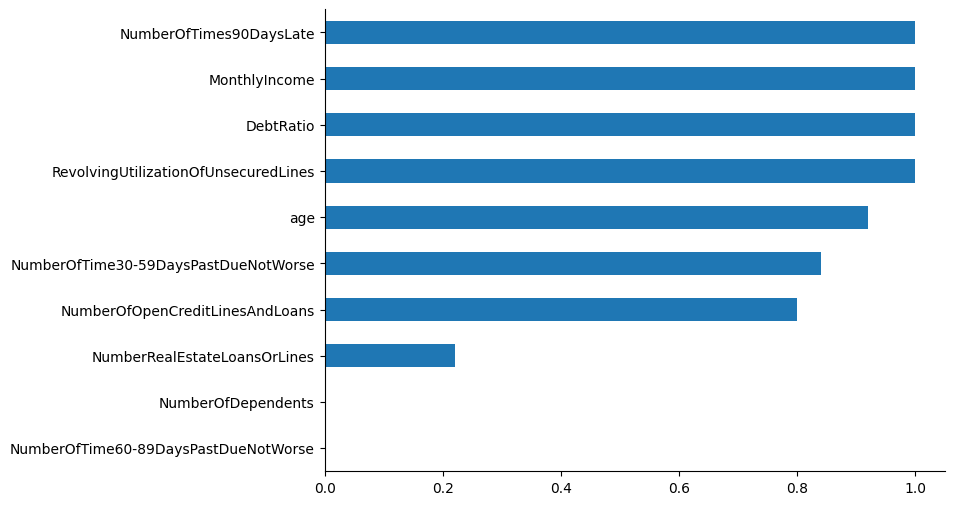

In [13]:
pd.Series(local_feat_importance.local_importance[0]).sort_values().plot(kind='barh');

In [14]:
global_feat_importance = dice_exp.global_feature_importance(X_trainval[y_trainval==1].iloc[:50])

100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


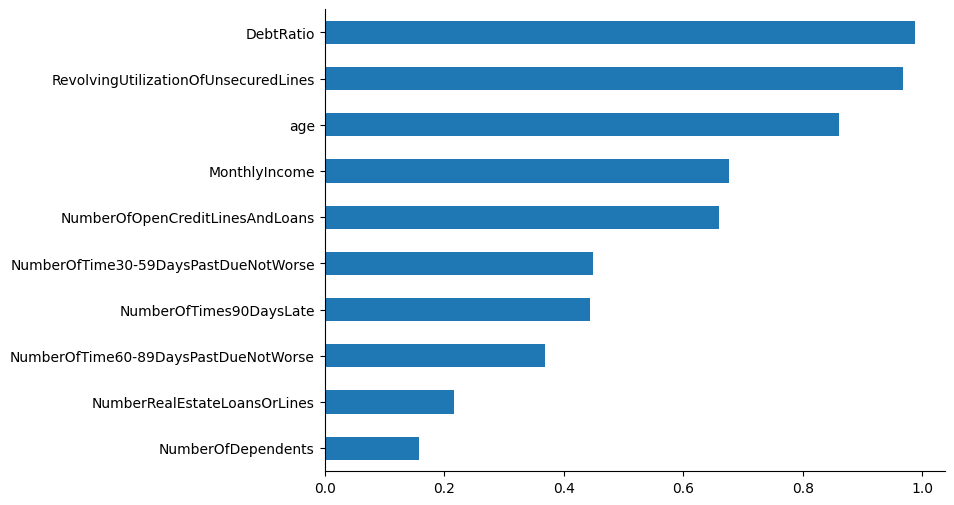

In [15]:
pd.Series(global_feat_importance.summary_importance).sort_values().plot(kind='barh');

## Advantages and Disadvantages (DICE)

**Advantages**

- Counterfactual explanations provide contrastive and clear interpretations of the local prediction of the model. Since we also use the black box model itself and no surrogate models, we won't worry about differences in prediction capability of the black box model and surrogate model.
- Counterfactual technically only needs the prediction function. Although access to the training data enable us to check whether our counterfactual can actually be realized, the fact that we can infer counterfactuals without it is quite powerful specially on scenarios where there is high security and legal requirement regarding model and data disclosure.
- Counterfactual explanations can be implemeneted stratightforwardly. Although performance-wise, using optimizer library may be more efficient in reducing the loss function.

**Disadvantage**

- *The Rashomon effect*. As observed you can find several mulple counterfactual explanations for a given instance. Some of which may not make sense. The question also of how many should you report to your stakeholders become apparent.

# LIME (Local Interpretable Model-Agnostic Explanations)

[Local Interpretable Model-agnostic Explanations (LIME)](http://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf) is a Python project developed by Ribeiro et al. to interpret the predictions of any supervised Machine Learning (ML) model. [[2]](#ref:lime)

<img title="LIME Paper" alt="Alt text" src="figures/LIME_paper.png" width="550">
<b><center>
Local Interpretable Model-agnostic Explanations (LIME) Paper  by Ribeiro et al.
</center></b>

Local explanations are based directly on a single observation. Using local explanations, we attempt to understand why ƒ generated that particular prediction for that specific sample. For any given sample, local explanations typically answer the question: “Which features most influenced this specific prediction?”

## Intuition

LIME attempts to **approximate the model’s mapping function** $ƒ(𝒙)$ by sampling instances (referred to as input perturbation). 

In layman terms, LIME generates a bunch of synthetic samples $𝒙’$ which are closely based on the original instance $𝒙$. LIME then passes $𝒙’$ to the original model $ƒ$ and records the respective prediction. This process enables LIME to determine how the different input fluctuations are influencing $ƒ$. At the end of the process, for a given sample $𝒙$, LIME would be able to approximate the prediction of ƒ by determining the individual influence of every feature. Therefore, LIME is able to explain a specific prediction by understanding which features had the most contribution to the prediction.

**Summary**

- 🍈 samples instances $𝒙’$
- 🍈 uses $𝒙’$ to generate a set of predictions $𝑦’$ using ƒ(𝒙)
- 🍈 compares the prediction’s proximity to the original prediction and weights them.
- 🍈 uses the weights to determine which features are the most influential to that individual prediction.

**Toy example to present intuition for LIME**

<img title="LIME Toy Explanation" alt="Alt text" src="figures/LIME toy exp.png" width="500">
<b><center>Image taken from the LIME article. </center></b>

The black-box model’s complex decision function $f$(unknown to LIME) is represented by the blue/pink background, which cannot be approximated well by a linear model. The bold red cross is the instance being explained. LIME samples instances, gets predictions using $f$, and weighs them by the proximity to the instance being explained (represented here by size). *The dashed line is the learned explanation that is locally (but not globally) faithful.*

## Theory

As previously mentioned, the whole idea of LIME is to attempt to interpret $ƒ(𝒙)$. LIME achieves this through surrogate models. A surrogate model $g$ is any model which is used to interpret the results of another predictive algorithm. Typically, $g$ would be a much simpler and much more interpretable model (like a decision tree or a linear model). We can formally define the set of surrogate models as $G$, such that $g ∈ G$.


**But, how does LIME select which $g$ to use for interpreting the original model?**

There are two main deciding factors that are considered by LIME:

1. **Local Faithfulness**, denoted by $L(f, g, π)$ — also called **fidelity** function
2. **Complexity**, denoted by $Ω(g)$

Let's discuss **Local Faithfulness** first. We'll break this down into two parts:

**Local**

Local simply means that we are focusing on one specific prediction at a time rather than considering ƒ holistically.

**Faithfulness**

This is a measure of how accurately our selected $g$ is able to follow the original model $ƒ$. The closer the predictions of $g$ to those of $ƒ$, the more faithful $g$ is said to be of $ƒ$. We refer to the *closeness* of the two predictions as the proximity, which is mathematically defined as $π$.

Now focusing on what **Complexity** means:

The main motivation behind $g$ is to interpret $ƒ$. Therefore, $g$ must be interpretable. The simpler the $g$, the more interpretable it becomes.

Complexity is measured in different ways, depending on the type of model being evaluated. For instance, in decision trees, the complexity can be directly given by the depth of the tree (the deeper the tree, the more complex and the less interpretable). In linear models, complexity might be measure in the number of non-zero weights.

**LIME attempts to minimize complexity and maximize faithfulness**

\begin{equation}
\xi(x) = \underset{g\in G}{argmin} L(f, g, π) + Ω(g)
\end{equation}
 
The fidelity function $L(f, g, π)$ can be defined by any loss function. LIME uses a square loss distance function. The loss function also changes depending on the type of model to be interpreted (an image classifier will require a different loss function than a tabular one). 

Now, let’s get our hands dirty with a Python example!

## Implementation

In [16]:
from lime.lime_tabular import LimeTabularExplainer

In [17]:
lime_explainer = LimeTabularExplainer(
    X_trainval.to_numpy(),
    feature_names=X_trainval.columns
)

In [18]:
lime_exp = lime_explainer.explain_instance(
    X_holdout.iloc[0],
    pipe.predict_proba,
    num_features=10
)

/Users/ken/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [19]:
lime_exp.show_in_notebook(show_all=True)

## Advantages and Disadvantages (LIME)

**Advantages**

- Using a **surrogate model** allows you to choose an interpretable model that is ideal for your use-case. Whether it be a model that your stakeholders or fellow developers are familiar with. Intrinsic models have an inherent advantage of having more extensive literature and industry usage.
- By controlling the complexity of the surrogate model, you can create **selective** explanations. This can be done by regularizing the surrogate model being used.
- LIME package provides documentation for tabular, text, and image data with visualizations that are ready for interpretattion.
- The **fidelity** measure provides a quantitative measure of how good the explanation method is in approximating the original black box model.

**Disadvantage**

- The definition of the neighborhood to which we take the sample can be ambiguous. To test for its robustness, we may try to change different `kernel_widths` or `kernel` functions and see if the explanation makes sense. With that said some authors reported instability with the explanations provided by LIME. [[3]](#ref:instability) Always be cautious with interpreting the results.
- The sampling procedure ignores the possible correlation between features. As such, it is advisable to check for correlation of features beforehand.

# SHAP (Shapley Additive Explanations)

SHAP is a technique developed by **Lundberg and Lee in 2017** for interpreting ML model predictions using Shapely values. The central principle of SHAP is to compute the Shapley values for each characteristic of the sample to be interpreted, where each Shapley value indicates the influence that the related feature has on the prediction.

The concept of SHAP is simple to grasp. That is, there is a Shapley value for *every feature*. But how does SHAP work?

To understand this, we must first discuss the concept of Shapley values.

## Shapley Values

Shapley values is a solution in cooperative game-theory answering how to distribute a **gain** of a **coalition** *fairly* by considering the outcome of each possible combination (or coalition) of **players** to determine the importance of each player. The distribution is based on the **expected marginal contribution** of a player when it joins the coalition (at every possible ordering).

To understand the significance of Shapley values and how it is computed, let us consider the following demonstration [[4]](#ref:shap-how).

Say that in a certain RPG game, a Dragon Quest was offered by a certain dungeon master:

<img src="figures/dragon_quest/1.png" align="center" width="250"/>

*\"For every dragon tamed, your team gets a thousand gold coins\"* the Dungeon Master said.

Heeding the call of this dragon quest are the band of brave adventurers: The (1) Fiesty Sorcerres, (2) Mighty Knight, and the (3) Keen Archer.

<img src="figures/dragon_quest/2.png" align="center" width="400"/>

For the duration of the quest, the three tamed *30 dragons* granting them a total bounty of *30 thousand gold*!

Initially, the team thought of distributing the bounty *evenly*, granting each member a take-home bounty of *10 thousand gold* each. However, the Fiesty Sorceress reacted: *\"It is my spells that weaken the dragons that we encountered, I think it is not fair that I don't get a bonus in the bounty that we have!\"*

This presents a dillema, since giving the Fiesty Sorceress a bonus means cutting the share of some of the other members. The question now is: ***Is there any truth to the claim of the Fiesty Sorceress? How should we distribute the bounty fairly among the members of the team?***

Here is where the Shapley values becomes useful. By considering the *expected marginal contribution* of each member as they enter the coalition in all possible ordering, we can compute for the amount of bounty that each player should receive.

As a demonstration, let's compute the Shapley value of the Fiesty Sorceress and see if there's any truth to her claim.

<img src="figures/dragon_quest/3.png" align="center" width="450"/>

The Fiesty Sorceress can enter the coalition in four different scenarios: (1) Coming from **No Members** $\varnothing$ to a single player (Fiesty Sorceress); (2) Joining the **Brave Knight** forming a party of 2 (Brave Knight, Fiesty Sorceress); (3) Joining the **Keen Archer** forming a party of 2 (Keen Archer, Fiesty Sorceress); and (4) Joining the team of **Brave Knight and Keen Archer** forming a party of 3 (Brave Knight, Keen Archer, Fiesty Sorceress).

We then compute the **marginal contribution** of the Fiesty Sorceress as she enters the coalition from these four scenarios:

1. $\varnothing$ to **(Fiesty Sorceress)**: 10 dragons - 0 dragons = **10 dragons**
2. **(Brave Knight)** to **(Brave Knight, Fiesty Sorceress)**: 20 dragons - 5 dragons = **15 dragons**
3. **(Keen Archer)** to **(Keen Archer, Fiesty Sorceress)**: 16 dragons - 8 dragons = **8 dragons**
4. **(Brave Knight, Keen Archer)** to **(Brave Knight, Keen Archer, Fiesty Sorceress)**: 30 dragons - 18 dragons = **12 dragons**

To compute for the **expected marginal contribution** of the Fiesty Sorceress (or equivalently, her Shapley value $\phi_S$), we have to weight these marginal contributions according to each scenario:

$$
\phi_S = 10 \times w_1 + 15 \times w_2 + 8 \times w_3 + 12 \times w_4 \tag{1}
$$

Now, how do we determine the values of the weights $w_1$, $w_2$, $w_3$, and $w_4$? There are three key ideas:

1. Since we are computing for the **expected** marginal contribution, the sum of all the weights should reduce to unity:

$$
w_1 + w_2 + w_3 + w_4 = 1 \tag{2}
$$

2. Next, we impose that weights $w_2$ and $w_3$ should have the same value. Since, in both scenarios, the Fiesty Sorceress enters the coalition from a party of one.

$$
w_2 = w_3 \tag{3}
$$

3. Finally, notice that the Fiery Sorceress enters at three distinct scenario: (1) from no player, (2) from a party of one, and (3) from a party of two. We impose that the weights resulting from these scenarios should be equivalent, that is:

$$
w_1 = w_2 + w_3 = w_4 \tag{4}
$$

Combining Equations these three equations, we get:

$$
w_1 = \frac{1}{3} \\
w_2 = w_3 = \frac{1}{6}  \\
w_4 = \frac{1}{3} \tag{5}
$$

Thus, we can finally compute for the expected marginal contribution or Shapley value $\phi_S$ of the Fiesty Sorceress:

$$
\phi_S = 10 \cdot \frac{1}{3} + 15 \cdot \frac{1}{6} + 8 \cdot \frac{1}{6} + 12 \cdot \frac{1}{3} = 11 \frac{1}{6} \approx 11 \tag{6}
$$

In the end, it seems that the Fiesty Sorceress provide some truth in her claim! Her Shapley value tell us that her contribution to the team is equivalent to *11 Dragons*, which means, she should get a total share of *11 thousand gold* of bounty!

<div class="alert alert-info">
    
### ⚠️ Exercise

Can you compute the Shapley values of the other team members (Brave Knight and Keen Archer)? Who gets a lower gold share compared to the average? How can we explain (and possibly argue) to that team member that they should get a smaller share of the gold?

*Note: You may find the [Figure 1](#fig:dragon-quest) helpful in your computation. Grey arrows represent the Brave Knight joining the coalition, while green arrows represent the Keen Archer joining the coalition.*
    
</div>

<a name='fig:dragon-quest'></a>
<div>
    <img src="figures/dragon_quest/4.png" align="center" width="450"/>
</div>

<br style="clear:both" />

<div>
    <p style="font-size:12px;font-style:default;">
        <b>Figure 1. Different possible coalitions and the corresponding weights and gains for each scenario.</b><br>
           Each arrow represents a player entering the coalition. Grey arrows represent the Brave Knight joining the coalition, green arrows represent the Keen Archer, and the red arrows represent the Fiesty Sorceress.
    </p>
</div>

Now that we understand the significance of Shapley values and how they are computed in practice, we can proceed to derive a mathematical formula for it.

Recall that by definition Shapley value is the **expected marginal contribution** of a player $i$ to the coalition it joins if the method of coalition formation is that each player enters one at a time [[5]](#ref:shapley-handbook). As such, for a given set of $N$ players, and for each non-empty subset $S$ of $N$, we can write the definition of Shapley value $\phi_i$ for player $i$ in terms of probability as follows:

$$
\phi_i = E(MC_i) = \sum_{S \subseteq N} P(S) MC_{i,S} \tag{7}
$$

Here, $P(S)$ represents the probability of $i$ joining the coalition to form $S$ and $MC_{i, S}$ is the marginal contribution as a results of $i$ joining the coalition.

To calculate $P(S)$, let us consider the case when player $i$ joins the coalition to form set $S$ with $s$ members. Denoting $n$ as the total number of players, there are $n!$ possible orderings. To form the subset coalition $S$, note that other members of $S$ can enter before player $i$ in $(s-1)!$ permutations and the remaining players can enter in $(n-s)!$ permutations. Therefore, $P(S)$ may be given by:

<div>
    <img src="figures/prob-s.png" align="center" width="450"/>
</div>

Furthermore, to formalize our definition, let $v(S)$ refer to the gain of the coalition subset $S \subseteq N$ and $S \, \backslash \, \{ i \}$ refer to the coalition subset $S$ but without player $i$. The marginal contribution of $i$ as it enters $S \, \backslash \, \{ i \}$, $MC_{i, S}$, can therefore be written as:

$$
MC_{i, S} = v(S) - v(S \, \backslash \, \{ i \})
$$

Combining equations these three equations, we get our **mathematical definition** of **Shapley values** as:

<div>
    <img src="figures/shapley-math.png" align="center" width="600"/>
</div>

<div class="alert alert-info">

### ⚠️ Exercise

You may have noticed that for every row in [Figure 6](#fig:dragon-quest), the fractions add up to one:

1. A player enters the coalition from $\varnothing$ to one member: $\frac{1}{3} + \frac{1}{3} + \frac{1}{3} = 1$
2. A player enters the coalition from one member to two members: $6 \cdot \frac{1}{6} = 1$
3. A player enters the coalition from two members to three members: $\frac{1}{3} + \frac{1}{3} + \frac{1}{3} = 1$

Can you reconcile this result with our prior discussion wherein we define Shapley values in terms of probability?

</div>

## SHAP

SHAP adopts this notion of using Shapley values to determine the **contribution** of a feature value with respect to the prediction of the model. 

Recall that there are two key elements in cooperative game theory: **gain** and the **players**. When using Shapley values to explain machine learning models, we define the **gain** as the **outcome of the model** for a *single observation* and the **players** as **feature values** of that observation. A **coalition** would then correspond to a subset of feature values used in prediction. Thus, the obtained **Shapley values** would correspond to the **expected marginal contribution** of the feature value to the model's prediction. This expected marginal contribution reflects how the model prediction outcome deviated from the mean or naive prediction due to the observed feature value.

Notice that calculating this for multiple features might become **intractable**. To alleviate this, the authors developed **Kernel SHAP**, an expanded and modified technique for alculating Shapley values based on linear LIME.

KernelSHAP proceeds using these five steps:

- Sample coalitions $z_k^{'} \in \{0, 1\}^M, k \in \{1, ..., K\}$. 1 means feature is present in a coalition, and 0 means the feature is absent.
- Get the prediction for each $z^{'}_k$ by converting $z^{'}_k$ to the original feature space, and then getting the prediction of the model given the set of features.
- Compute the weight for each $z^{'}_k$ with the SHAP kernel
- Fit a weighted linear model
- Return the Shapley values $\phi_k$ as the coefficients from the linear model.

## Implementation

Kernel Shap is the only method model-agnostic for the calculation of Shapley values, that is, **Kernel Shap** can interpret any ML model regardless of its nature. On the other hand, the authors also proposed other variants to obtain Shapley values based on different types of models such as **Tree SHAP**, **Deep SHAP**, and **Linear SHAP**.

SHAP has a list of classes that again uses Shapley values to explain any machine learning model or python function. These classes are commonly referred to as explainers. This explainer generally takes the ML model and data as input and returns an explainer object, which has SHAP values. This  will then be used to plot various charts explained that we will show later on. 

Some of the frequently used explainers are as follows:


1. **KernelExplainer** - This explainer uses the Kernel SHAP method to explain the output of any function. Kernel SHAP is a method that uses a special weighted linear regression to compute the importance of each feature. The computed importance values are Shapley values from game theory and also coefficents from a local linear regression.
2. **LinearExplainer** - This explainer is used for linear models available from sklearn. It can account for the relationship between features as well.
3. **TreeExplainer** - Uses Tree SHAP algorithms to explain the output of ensemble tree models. Tree SHAP is a fast and exact method to estimate SHAP values for tree models and ensembles of trees, under several different possible assumptions about feature dependence.
4. **DeepExplainer** - This explainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples.

Below is a list of all other available explainers with SHAP.

1. **AdditiveExplainer** - This explainer is used to explain Generalized Additive Models.
2. **BruteForceExplainer** - This explainer uses the brute force approach to find shap values which will try all possible parameter sequence.
3. **GradientExplainer** - This explainer is used for differentiable models which are based on the concept of expected gradients which itself is an extension of the integrated gradients method.
4. **PartitionExplainer** - This explainer calculates shap values recursively through trying a hierarchy of feature combinations. It can capture the relationship between a group of related features.
5. **PermutationExplainer** - This explainer iterates through all permutation of features in both forward and reverses directions. This explainer can take more time if tried with many samples.
6. **SamplingExplainer** - This explainer generates shap values based on assumption that features are independent and is an extension of an algorithm proposed in the paper "An Efficient Explanation of Individual Classifications using Game Theory".
7. **CoefficentExplainer** - This explainer returns model coefficients as shap values. It does not do any actual shap values calculation.
8. **LimeTabularExplainer** - This explainer simply wrap around LimeTabularExplainer from lime library. If you are interested in learning about lime then please feel free to check on our tutorial on the same from references section.
9. **MapleExplainer** - This explainer simply wraps MAPLE into shap interface.
10. **RandomExplainer** - This explainer simply returns random feature shap values.
11. **TreeGainExplainer** - This explainer returns global gain/Gini feature importances for tree models as shap values.
12. **TreeMapleExplainer** - This explainer provides a wrapper around tree MAPLE into shap interface.

<div class="alert alert-info">

### Note

The drawback of the KernelExplainer is its long running time. If your model is a tree-based machine learning model, you should use the tree explainer `TreeExplainer()` that has been optimized to render fast results. If your model is a deep learning model, use the deep learning explainer `DeepExplainer()`. The SHAP Python module does not yet have specifically optimized algorithms for all types of algorithms.
</div>

Below is a list of available charts with SHAP, but today we will only focus on a few of this for today's session.

1. **force_plot** - It plots shap values using additive force layout. It can help us see which features most positively or negatively contributed to prediction.
2. **summary_plot** - It creates a beeswarm plot of shap values distribution of each feature of the dataset.
3. **dependence_plot** - It shows relationship between feature value (X-axis) and its shape values (Y-axis).
4. **decision_plot** - It shows the path of how the model reached a particular decision based on shap values of individual features. The individual plotted line represents one sample of data and how it reached a particular prediction.
5. **multioutput_decision_plot** - Its decision plot for multi output models.
6. **image_plot** - It plots shape values for images.
7. **monitoring_plot** - It helps in monitoring the behavior of the model over time. It monitors the loss of model overtime.
8. **embedding_plot** - It projects shap values using PCA for 2D visualization.
9. **partial_dependence_plot** - It shows basic partial dependence plot for a feature.
10. **bar_plot** - It shows a bar plot of shap values impact on the prediction of a particular sample.
11. **waterfall_plot** - It shows a waterfall plot explaining a particular prediction of the model based on shap values. It kind of shows the path of how shap values were added to the base value to come to a particular prediction.
12. **text_plot** - It plots an explanation of text samples coloring text based on their shap values.

In [20]:
import shap

In [21]:
shap_explainer = shap.Explainer(pipe.predict_proba, X_trainval, feature_names=X.columns)

In [22]:
shap_values = shap_explainer(X_holdout.iloc[:1000, :])

ExactExplainer explainer: 1001it [01:10, 12.64it/s]                          


In [23]:
shap_explanation = shap.Explanation(shap_values.values[:, :, 1],
                                    shap_values.base_values[0][1],
                                    shap_values.data,
                                    feature_names=X.columns)

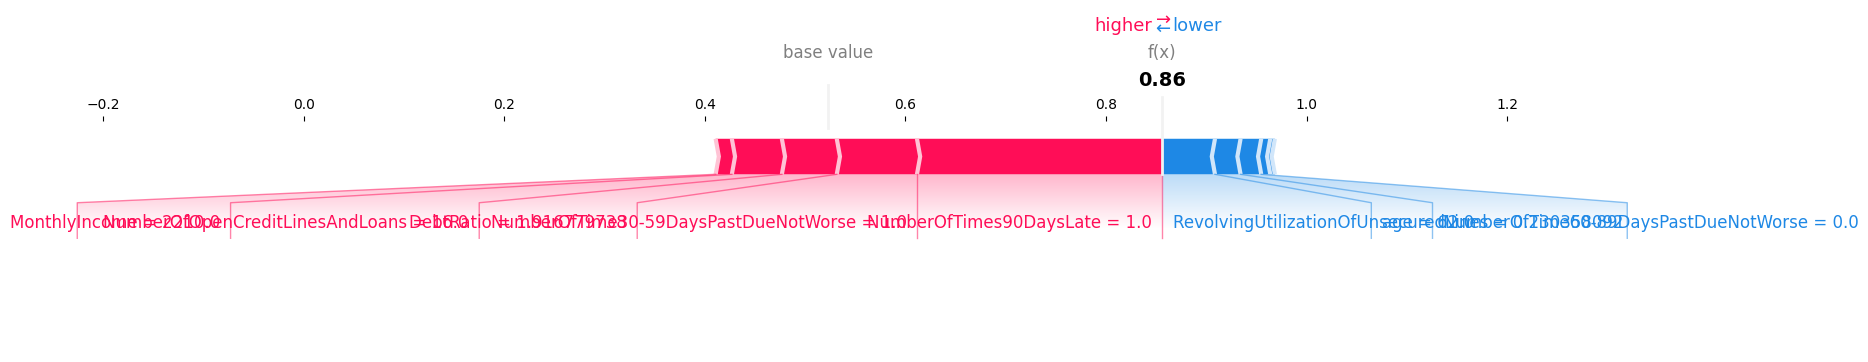

In [24]:
shap.force_plot(shap_explanation[0], matplotlib=True)

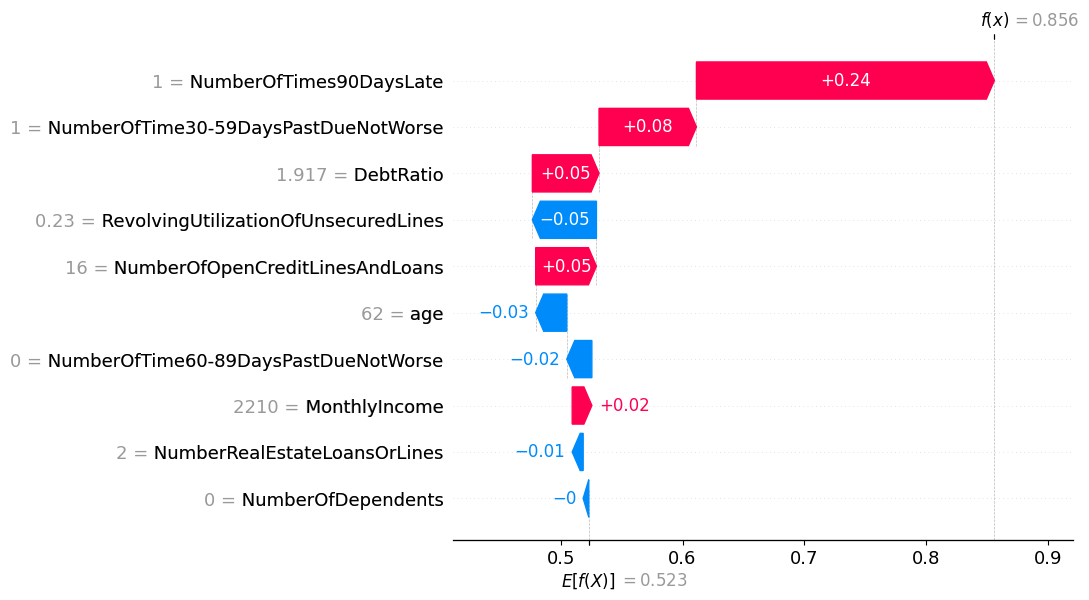

In [25]:
shap.plots.waterfall(shap_explanation[0])

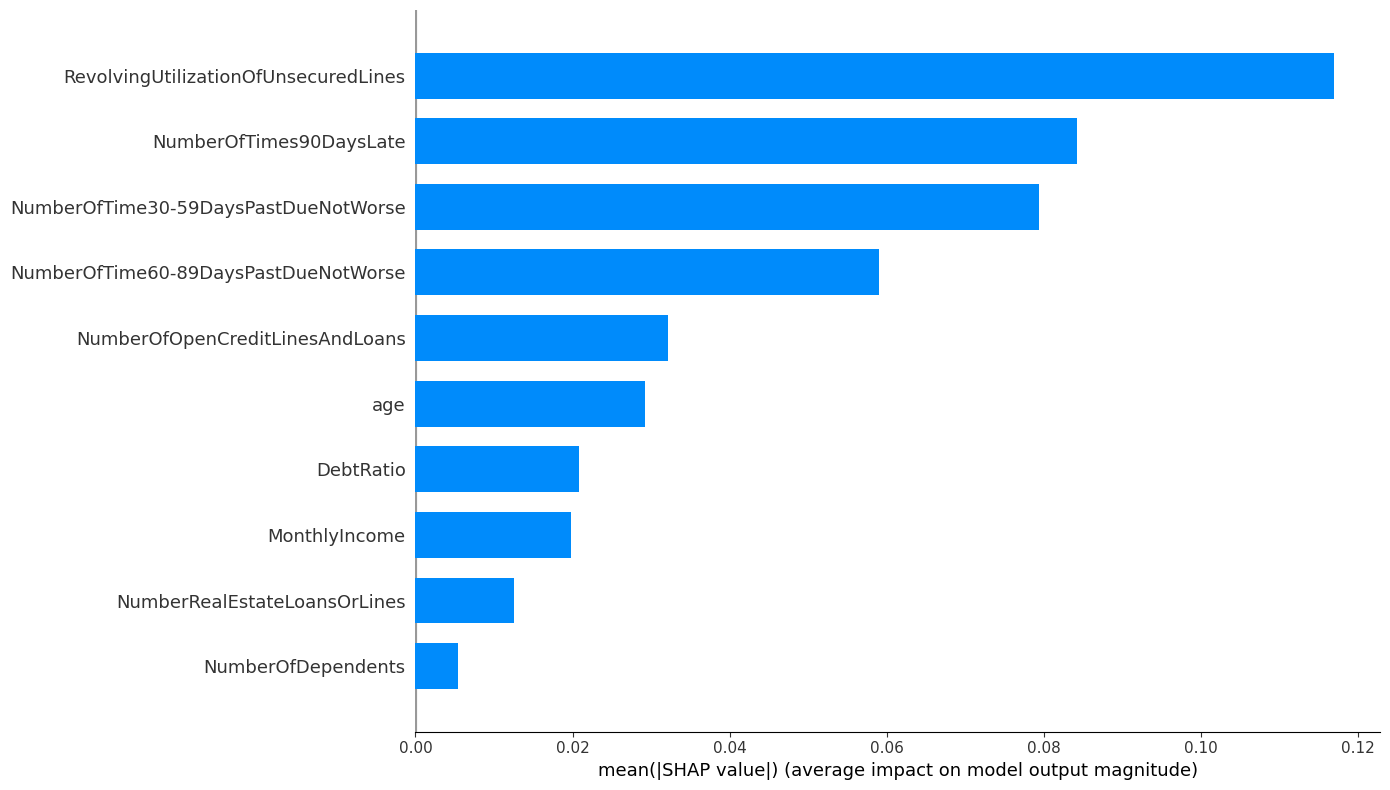

In [26]:
shap.summary_plot(shap_explanation, plot_type='bar', plot_size=(14, 8))

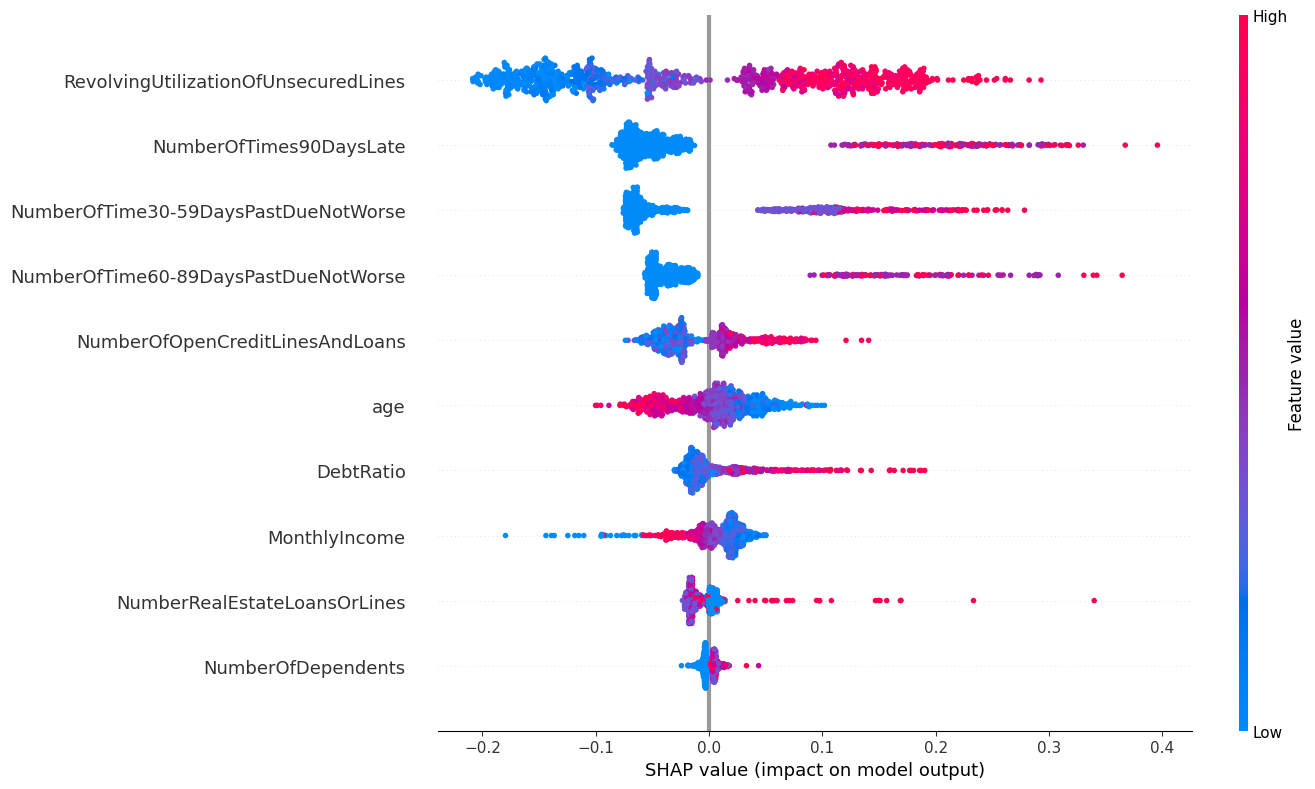

In [27]:
shap.summary_plot(shap_explanation, plot_size=(14, 8))

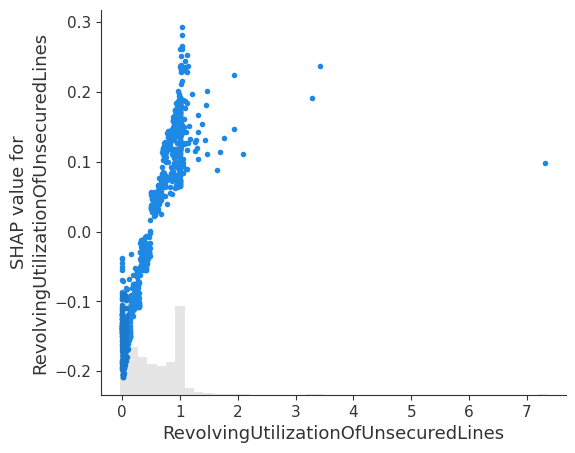

In [28]:
shap.plots.scatter(shap_explanation[:, 'RevolvingUtilizationOfUnsecuredLines'])

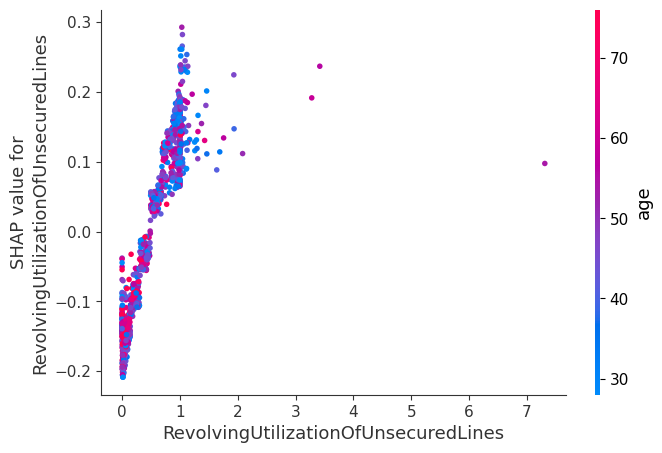

In [29]:
shap.dependence_plot(ind='RevolvingUtilizationOfUnsecuredLines',
                     shap_values=shap_explanation.values,
                     features=shap_explanation.data,
                     feature_names=X.columns,
                     interaction_index='age')

## Advantages and Disadvantages (SHAP)

**Advantages**
- Computed importance from SHAP retains all the theoretical properties of Shapley values.
- SHAP provides contrastive explanation such that it compares the current instance of interest with the average prediction.
- SHAP combines LIME and Shapley values.
- SHAP is optimized for tree-based or linear models.

**Disadvantages**
- KernelSHAP although provides explanation for any blackbox model, it can be computationally expensive still.
- KernelSHAP ignores feature dependence.

## Video Resources
You can check online resources like YouTube for a variety of explanations on how to interpret SHAP values and plots. These are examples and not an endorsement:
- https://www.youtube.com/watch?v=MQ6fFDwjuco
- https://www.youtube.com/watch?v=FiVevA8fBgg
- https://www.youtube.com/watch?v=L8_sVRhBDLU
- https://www.youtube.com/watch?v=zIbQgYxRBUc

<div class="alert alert-block alert-info">

# ⚠️ Checkpoint ⚠️
In the next 10 minutes, discuss the following with your LT:

1. What are the key differences between the 3 methods: **DICE, LIME, SHAP**?
2. What situations would you use each of the 3 over the others?
3. Familiarize yourselves with how to interpret the graphs or numerical results of each.

<u>As a review</u>: what again is the difference between **intrinsic and post-hoc** explainability methods?
</div>

# References
- <a name='ref:molnar'></a> [1] Molnar, Christoph. “Interpretable machine learning. A Guide for Making Black Box Models Explainable”, 2019. https://christophm.github.io/interpretable-ml-book/.
- <a name='ref:dandl'></a> [2] Dandl, Susanne, Christoph Molnar, Martin Binder, Bernd Bischl. “Multi-objective counterfactual explanations”. In: Bäck T. et al. (eds) Parallel Problem Solving from Nature – PPSN XVI. PPSN 2020. Lecture Notes in Computer Science, vol 12269. Springer, Cham (2020)
- <a name='ref:lime'></a> [3] Ribeiro MT, Singh S, Guestrin C. " Why should i trust you?" Explaining the predictions of any classifier. InProceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining 2016 Aug 13 (pp. 1135-1144).
- <a name='ref:instability'></a> [4] Alvarez-Melis, David, and Tommi S. Jaakkola. “On the robustness of interpretability methods.” arXiv preprint arXiv:1806.08049 (2018)
- <a name='ref:shap-how'></a> [5] Mazzanti, Samuele. "SHAP Values Explained Exactly How You Wished Someone Explained to You." *Towards Data Science*, 04 Apr. 2020, https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30
- <a name='ref:shapley-handbook'></a> [6] Algaba, Encarnación, Vito Fragnelli, and Joaquín Sánchez-Soriano, eds. *Handbook of the Shapley value*. CRC Press, 2019.
- <a name='ref:shap'></a> [7] Lundberg SM, Lee SI. A unified approach to interpreting model predictions. Advances in neural information processing systems. 2017;30.